In [0]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "/gdrive/My Drive"
categories = ["dog", "cat", "butterfly", "horse"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpeg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
          print(cat, " : ", f)
        if i==1999:
          break

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("/gdrive/My Drive/multi_image_data.npy", xy)

print("ok", len(y))

dog  파일 길이 :  4906
dog  :  /gdrive/My Drive/dog/OIP-tzQyasEAGo5Abdzc_AKyxAHaHa.jpeg


KeyboardInterrupt: ignored

In [0]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('/content/gdrive/My Drive/multi_image_data.npy')
print(X_train.shape)
print(X_test.shape)


Using TensorFlow backend.


(5610, 64, 64, 3)
(1871, 64, 64, 3)


In [0]:
categories = ["dog", "cat", "butterfly", "horse"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [0]:
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3,3), padding="same", activation='relu'))
    model.add(Conv2D(256, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['accuracy'])
    model_dir = '/content/gdrive/My Drive'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification2.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 128)      

In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Train on 4488 samples, validate on 1122 samples
Epoch 1/100
4488/4488 [==============================] - 18s 4ms/step - loss: 1.3736 - acc: 0.3001 - val_loss: 1.3641 - val_acc: 0.3904

Epoch 00001: val_loss improved from inf to 1.36414, saving model to /content/gdrive/My Drive/multi_img_classification2.model
Epoch 2/100
4488/4488 [==============================] - 16s 4ms/step - loss: 1.2863 - acc: 0.3964 - val_loss: 1.1460 - val_acc: 0.5196

Epoch 00002: val_loss improved from 1.36414 to 1.14598, saving model to /content/gdrive/My Drive/multi_img_classification2.model
Epoch 3/100
4488/4488 [==============================] - 16s 4ms/step - loss: 1.0474 - acc: 0.5437 - val_loss: 1.0169 - val_acc: 0.5499

Epoch 00003: val_loss improved from 1.14598 to 1.01694, saving model to /content/gdrive/My Drive/multi_img_classification2.model
Epoch 4/100
4488/4488 [==============================] - 16s 4ms/step - loss: 0.9781 - acc: 0.5818 - val_loss: 0.9608 - val_acc: 0.6078

Epoch 00004: val_loss

In [0]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

1871/1871 [==============================] - 1s 758us/step
정확도 : 0.7600


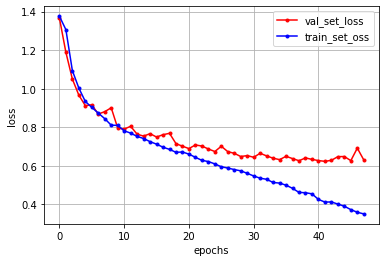

In [0]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

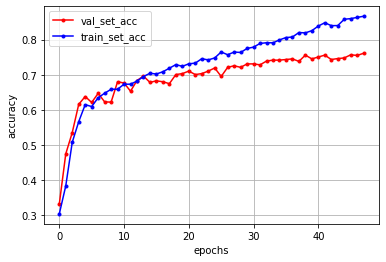

In [0]:
y_vloss = history.history['val_acc']
y_loss = history.history['acc']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_acc')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

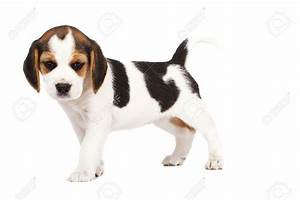

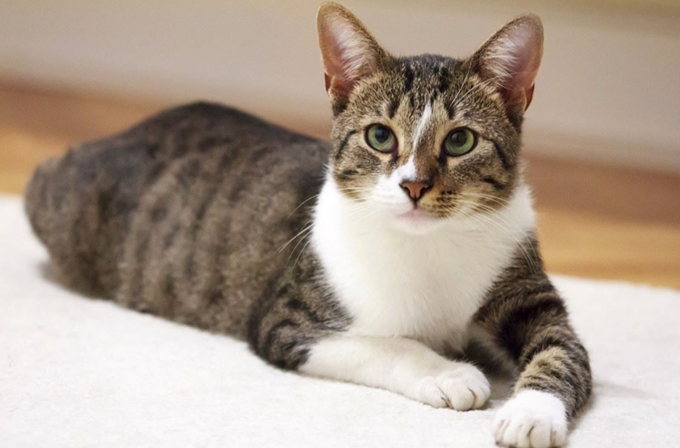

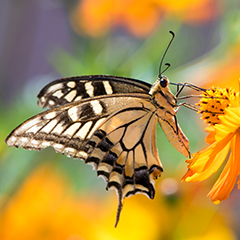

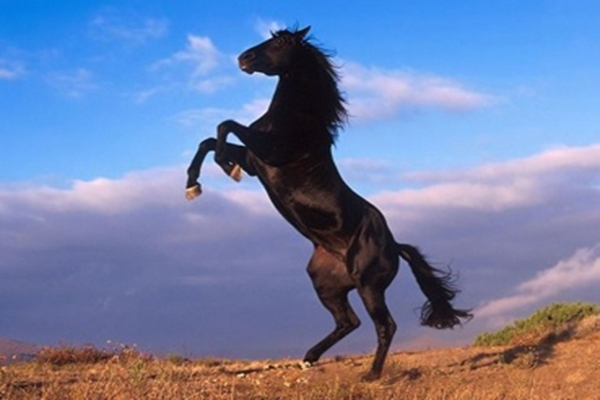

[1.000 0.000 0.000 0.000]
0
해당 /gdrive/My Drive/imgs_test/dog1.jpeg이미지는 개로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 /gdrive/My Drive/imgs_test/horse1.jpeg이미지는 말로 추정됩니다.
[0.000 0.000 1.000 0.000]
2
해당 /gdrive/My Drive/imgs_test/butterfly1.jpeg이미지는 나비로 추정됩니다.
[0.000 1.000 0.000 0.000]
1
해당 /gdrive/My Drive/imgs_test/cat1.jpeg이미지는 고양이으로 추정됩니다.


In [0]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow

caltech_dir = "/gdrive/My Drive/imgs_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
image = cv2.imread("/gdrive/My Drive/imgs_test/dog1.jpeg", cv2.IMREAD_ANYCOLOR)
cv2_imshow(image)
image = cv2.imread("/gdrive/My Drive/imgs_test/cat1.jpeg", cv2.IMREAD_ANYCOLOR)
cv2_imshow(image)
image = cv2.imread("/gdrive/My Drive/imgs_test/butterfly1.jpeg", cv2.IMREAD_ANYCOLOR)
cv2_imshow(image)
image = cv2.imread("/gdrive/My Drive/imgs_test/horse1.jpeg", cv2.IMREAD_ANYCOLOR)
cv2_imshow(image)
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('/gdrive/My Drive/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "dog"
    elif pre_ans == 1: pre_ans_str = "cat"
    elif pre_ans == 2: pre_ans_str = "butterfly"
    else: pre_ans_str = "horse"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

In [7]:
import numpy as np
import os

np.random.seed(3)

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# 원본 이미지 위치 
optInputPath = '/content/gdrive/My Drive/Project/original'
# 늘릴 이미지가 저장될 위치
optOutputPath = '/content/gdrive/My Drive/Project/replicated/'

# 이미지 크기 조정 비율
optRescale = 1./255
# 이미지 회전 
optRotationRange=10
# 이미지 수평 이동
optWidthShiftRange=0.2
# 이미지 수직 이동
optHeightShiftRange=0.2
# 이미지 밀림 강도 
optShearRange=0.5
# 이미지 확대/ 축소 
optZoomRange=[0.9,2.2]
# 이미지 수평 뒤집기 
optHorizontalFlip = True 
# 이미지 수직 뒤집기 
optVerticalFlip = True
optFillMode='nearest'
# 이미지당 늘리는 갯수 
optNbrOfIncreasePerPic = 10
# 배치 수 
optNbrOfBatchPerPic = 1

'''
 총 개수 optNbrOfIncreasePerPic * optNbrOfBatchPerPic 
 예 >
 사진 1장에 
 optNbrOfIncreasePerPic = 5
 optNbrOfBatchPerPic = 5
 = 1 * 5 * 5 = 25장 생성  
'''

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=optRescale, 
                                   rotation_range=optRotationRange,
                                   width_shift_range=optWidthShiftRange,
                                   height_shift_range=optHeightShiftRange,
                                   shear_range=optShearRange,
                                   zoom_range=optZoomRange,
                                   horizontal_flip=optHorizontalFlip,
                                   vertical_flip=optVerticalFlip,
                                   fill_mode=optFillMode)
'''
폴더가 존재하는지 확인하고
없다면 생성 
'''
def checkFoler(path):
    try:
        if not(os.path.isdir(path)):
            os.makedirs(os.path.join(path))
    except OSError as e:
        if e.errno != errno.EEXIST:                        
            raise            

def increaseImage(path ,folder):
    for index in range(0,optNbrOfIncreasePerPic):                                   
        img = load_img(path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        # 부풀리는 이미지를 저장할 폴다가 존재하는지 확인
        # 없다면 생성 
        checkFoler(optOutputPath+folder)               
        print('index : ' + str(index))
        for batch in train_datagen.flow(x, batch_size=1, save_to_dir=optOutputPath+folder, save_prefix='tri', save_format='jpeg'):
            i += 1
            print(folder + " " + str(i))
            if i >= optNbrOfBatchPerPic: 
                break

def generator(dirName):
    checkFoler(optOutputPath)
    try:
        fileNames = os.listdir(dirName)
        for fileName in fileNames:
            fullFileName = os.path.join(dirName, fileName)
            if os.path.isdir(fullFileName):                
                generator(fullFileName)
            else:
                # 확장자 
                ext = os.path.splitext(fullFileName)[-1]
                # 폴더 이름 
                folderName = os.path.splitext(fullFileName)[0].split('/')[-2]
                if(ext == '.jpeg'):                    
                    increaseImage(fullFileName, folderName)               
                    
    except PermissionError:
        pass

if __name__ == "__main__":
        generator(optInputPath)  

index : 0
original 1
index : 1
original 1
index : 2
original 1
index : 3
original 1
index : 4
original 1
index : 5
original 1
index : 6
original 1
index : 7
original 1
index : 8
original 1
index : 9
original 1
index : 0
original 1
index : 1
original 1
index : 2
original 1
index : 3
original 1
index : 4
original 1
index : 5
original 1
index : 6
original 1
index : 7
original 1
index : 8
original 1
index : 9
original 1
index : 0
original 1
index : 1
original 1
index : 2
original 1
index : 3
original 1
index : 4
original 1
index : 5
original 1
index : 6
original 1
index : 7
original 1
index : 8
original 1
index : 9
original 1
index : 0
original 1
index : 1
original 1
index : 2
original 1
index : 3
original 1
index : 4
original 1
index : 5
original 1
index : 6
original 1
index : 7
original 1
index : 8
original 1
index : 9
original 1


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!pip install numpy==1.16.2
#!ls "/content/gdrive/My Drive/Project/original"
!pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 2.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4
